In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [2]:
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from collections import defaultdict

from skimage.segmentation import mark_boundaries
from glob import glob
import pandas as pd
import scipy
import cv2
import joblib

from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [4]:
import sys
sys.path.append('../torch_utils/')
sys.path.append('../utils')
sys.path.append('../zoo')
import rles
import dataset as ds
%load_ext autoreload
%autoreload 2
import ternaus_net
%load_ext autoreload
%autoreload 2
import enorm
%load_ext autoreload
%autoreload 2
import augmentations as augs
%load_ext autoreload
%autoreload 2
import learner as lrnr
%load_ext autoreload
%autoreload 2
import torch_funcs as thf
%load_ext autoreload
%autoreload 2
import losses
import metrics
import visualisation
import nms
%load_ext autoreload
%autoreload 2
import map_iou

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from retinanet import model as retinanet
import retinanet

In [6]:
PATHS = {
    'DATA': '../data/',
    'MASKS': '../data/masks/',
    'ARCHIVE': '../data/indianapolis/',
    'TRAIN': '../data/train',
    'TEST': '../data/test',
    'TEST2': '../data/test2',
    'CSV': '../data/csv',
}

PARAMS = {
    'PATHS': PATHS,
    'SEED': 42,
    'NB_FOLDS': 4,
    'PNG_SIDE': 512,
    'CUDA_DEVICES': [0, 1],
    'INVERSE': 3,
    'BATCH_SIZE': 42,
    'NB_EPOCHS': 31,
    'LR': 1e-5,
    'EXP_GAMMA': .8,
    'CUDA_DEVICES': [0, 1],
}

In [7]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [8]:
ddf = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_1_detailed_class_info.csv'))
ddf = ddf.drop_duplicates()
class_to_num = {
    'No Lung Opacity / Not Normal': 2, 
    'Lung Opacity': 1, 
    'Normal': 0
}
num_to_class = {
    2: 'No Lung Opacity / Not Normal', 
    1: 'Lung Opacity', 
    0: 'Normal'
}

ddf['class'] = ddf['class'].apply(lambda x: class_to_num[x])
ddf.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [9]:
df = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_1_train_labels.csv'))
df = df.dropna().drop(['Target'], axis=1)
df.head()

,patientId,x,y,width,height
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0


# DONT FORGET TO SHUFFLE TRAIN

In [10]:
def get_datagens(fold, paths_df, df, class_ddf, val_to_train=0):
    paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])

    paths_fold, paths_rest = ds.get_fold(paths, fold=fold, nb_folds=PARAMS['NB_FOLDS'], seed=42)
    if val_to_train:
        keys = sorted(list(paths_fold.keys()))
        rs = np.random.RandomState(seed=42)
        rs.shuffle(keys)
        for key in keys[:int(len(keys) * val_to_train)]:
            paths_rest[key] = paths_fold.pop(key)
        

    augments = augs.BBoxesAugmentation(side=512, strength=1.)
    augments_val = augs.BBoxesAugmentation(side=768, strength=0)
    dataset_train = ds.BBoxDataset(paths_rest, df, class_ddf, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.BBoxDataset(paths_fold, df, class_ddf, augments_val)
    esmplr = ds.EqualizedSampler(dataset_train, class_ddf)
    vsmplr = ds.ValSampler(dataset_val)
    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                sampler=esmplr,
                                                collate_fn=ds.bbox_collater,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=4)

    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              pin_memory=False,
                                              sampler=vsmplr,
                                              collate_fn=ds.bbox_collater,
                                              batch_size=PARAMS['BATCH_SIZE'],
                                              num_workers=0)
    return train_datagen, val_datagen

In [11]:
def orchestrate(learner, train_datagen, val_datagen, df=None,
                epchs_per_save=10,
                fold=0, epochs=1, hard_negative_miner=None,
                checkpoints_pth='../data/', lr_scheduler=None, 
                history=None, verbose=True, nb_freezed_epchs=0):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
    if history is None:
        history = defaultdict(list)
    try:
        os.mkdir(checkpoints_pth)
    except:
        pass
    last_epoch = len(history['train_losses'])
    print('last_epoch: {}'.format(last_epoch))

    ou = np.array([val_datagen.dataset.load_label(key) for key in tqdm(val_datagen.dataset.keys)])
    coeff = ou.sum(axis=0)[1] / ou.sum()
    print('coeff: {}'.format(coeff))

    for epoch_i in range(last_epoch, epochs):
        if hasattr(lr_scheduler, 'step'):
            lr_scheduler.step()
        learner.freeze_encoder(unfreeze=(epoch_i >= nb_freezed_epchs))

        meters = learner.train_on_epoch(
            train_datagen, 
            hard_negative_miner=hard_negative_miner,
            lr_scheduler=lr_scheduler
        )
        history['train_losses'].append(meters)

        meters = learner.validate(val_datagen)
        bbx_results = [m['results'] for m in meters]
        clf_results = None
        if 'clf_out' in meters[0].keys():
            clf_results = [m['clf_out'].numpy() for m in meters]
            clf_results = np.array(clf_results).squeeze()

        iou, threshold = map_iou.compute_maps(df, bbx_results, clf_results, coeff=coeff)
        pickle.dump([bbx_results, clf_results], open(path.format(fold, 'results_{}'.format(epoch_i)), 'wb'))

        meters = [{k: v for k, v in m.items() if k != 'results'} for m in meters]
        history['val_losses'].append({
            'meters': metrics.aggregate(meters),
            'iou': iou,
        })

        clear_output(wait=True)
        if verbose:
            visualisation.plot_retina_losses(history)
            print('Threshold: {}'.format(threshold))
            print(checkpoints_pth)
#             for i, el in enumerate(dist):
#                 print('{}\t--\t{}'.format(num_to_class[i], el))

            learner.infer_on_data(val_datagen.dataset[6], df, threshold=threshold)
            learner.infer_on_data(val_datagen.dataset[113], df, threshold=threshold)
            learner.infer_on_data(val_datagen.dataset[200], df, threshold=threshold)
#             if train_dataset.aug_params['strength'] > min_strength:
#                 train_dataset.aug_strength_decay(strength_decay)

        if (checkpoints_pth is not None) and (iou >= max([vl['iou'] for vl in history['val_losses']])) or ((epoch_i) % epchs_per_save == 0):
            state_dict = learner.model.state_dict()
            if isinstance(learner.model, torch.nn.DataParallel):
                state_dict = learner.model.module.state_dict()
            torch.save(state_dict, 
                       path.format(fold, epoch_i))
            print(path.format(fold, epoch_i))
        pickle.dump(history, open(path.format(fold, 'loss'), 'wb'))

#         train_dataset.converge_appearence(decay=converge_appearence)

    return learner, history

In [12]:
class RetinaLearner(lrnr.Learner):
    def __init__(self, model, loss, clf_loss=None, opt=None, metrics=[], ignored_keys=[], clf_reg_alpha=.5, betta=.5):
        self.alpha = clf_reg_alpha
        self.clf_loss = clf_loss
        self.betta = betta
        self.threshold = 0.05
        super(RetinaLearner, self).__init__(model, loss, opt, metrics, ignored_keys)

    def make_step(self, data, training=False):
        image = torch.autograd.Variable(data['img']).cuda()
        annot = data['annot']
        if len(image.shape) == 3:
            image = image.float().unsqueeze(dim=0)

        if len(data['label'].shape) == 1:
            data['label'] = torch.tensor(data['label']).float().unsqueeze(dim=0)

        if len(annot.shape) == 2:
            if annot.shape[0] == 0:
                annot = torch.ones(1, 5) * -1
            annot = torch.tensor(annot).unsqueeze(dim=0)
        output = self.model([
            image.float(), 
            annot.float()
        ])
        classification_loss, regression_loss = output['focal_loss']
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        results = { 
            'loss': self.alpha * classification_loss + (1 - self.alpha) * regression_loss,
            'bbx_reg_loss': regression_loss,
            'bbx_clf_loss': classification_loss,
        }

        if 'clf_out' in output.keys():
            clfl = clf_loss(output['clf_out'].float(), torch.tensor(data['label']).cuda().float())
            clf_results = {
                'clf_loss': torch.mean(clfl),
                'clf_out': output['clf_out'],
            }
            results.update(clf_results)
            results['loss'] = (self.betta * results['loss'] + (1 - self.betta) * results['clf_loss'])

        if 'nms_out' in output.keys():
            scores, labels, boxes = output['nms_out']
            results.update({ 
                'results': [{ 'image_id': data['pid'], 'score': 0 }]
            })
            if boxes.shape[1] == 4:
                results['results'] = self.process_bboxes(data, scores, labels, boxes)
                results['results'] = [{k: v.data.cpu() if hasattr(v, 'data') else v for k, v in r.items()} for r in results['results']]

        if training and bool((classification_loss + regression_loss) == 0):
            image = image.data.cpu()
            for key in results.keys():
                if key != 'results':
                    results[key] = results[key].data.cpu()
            return results

        if training:
            results['loss'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.opt.step()
#         for metric in self.metrics:
#             losses.update(metric(regression_loss, data['annot']))
        image = image.data.cpu()
        for key in results.keys():
            if key != 'results':
                results[key] = results[key].data.cpu()
        return results

    def validate(self, datagen):
        self.model.eval()
        meters = list()

        with torch.no_grad():
            for data in tqdm(datagen.dataset):
                meters.append(self.make_step(data, training=False))

        return meters

    def freeze_encoder(self, unfreeze=False):
        if hasattr(self.model, 'module'):
            model_ = self.model.module
        elif hasattr(self.model, 'encoder'):
            model_ = self.model
        encoders = [
            model_.conv1,
            model_.layer1,
            model_.layer2,
#             model_.layer3,
#             model_.layer4,
        ]
        for encoder in encoders:
            thf.freeze(encoder, unfreeze=unfreeze)
            thf.unfreeze_bn(encoder)

    def process_bboxes(self, data, scores, labels, boxes):
        # change to (x, y, w, h) (MS COCO standard)
#         boxes[:, 2] -= boxes[:, 0]
#         boxes[:, 3] -= boxes[:, 1]

        results = list()
        # compute predicted labels and scores
        #for box, score, label in zip(boxes[0], scores[0], labels[0]):
        for box_id, box in enumerate(boxes):
            score = float(scores[box_id])
            label = int(labels[box_id])

            # scores are sorted, so we can break
            if score < self.threshold:
                break

            # append detection for each positively labeled class
            image_result = {
                'image_id'    : data['pid'],
                'category_id' : int(label),
                'score'       : float(score),
                'bbox'        : box.tolist(),
            }

            # append detection to results
            results.append(image_result)
        return results

    def infer_on_data(self, data, df, verbose=True, k=2, threshold=.5):
        if self.model.training:
            self.model.eval()

        with torch.no_grad():
            result = self.make_step(data, training=False)
        image = data['img'].data.cpu().numpy() * ds.STD + ds.MEAN
        image = np.moveaxis(image, 0, -1)
        if verbose:
            top_k_annots = np.array([k['bbox']for k in result['results'] if k['score'] > threshold], dtype=int)
            score = np.array([k['score'] for k in result['results'] if k['score'] > threshold])
#             if len(top_k_annots):
#                 top_k_annots[:, 2] += top_k_annots[:, 0]
#                 top_k_annots[:, 3] += top_k_annots[:, 1]

            top_k_annots, idxs = nms.non_max_suppression_fast(top_k_annots, overlapThresh=.5)
            score = score[idxs]

            idxs = np.arange(len(top_k_annots)).tolist()
            idxs = sorted(idxs, key=lambda i: score[i], reverse=True)[:k + 1]
            top_k_annots = np.array(top_k_annots)
            top_k_annots = top_k_annots[idxs]
            print(score[idxs])
            if 'clf_out' in result.keys():
                print(torch.nn.functional.softmax(result['clf_out']))
                print(data['label'])

            data_pred = {
                'img': image,
                'annot': top_k_annots,
            }

            key = data['pid'].split('.')[0]
            annot = df.query('patientId==@key').drop(['patientId'], axis=1).values.astype(np.int)
            annot[:, 2] += annot[:, 0]
            annot[:, 3] += annot[:, 1]
            data_annot = {
                'img': image,
                'annot': annot,
            }
            visualisation.visualize_bboxes(data_pred, data_annot, {1: 'png'})
        
        return result

In [13]:
clf_loss = torch.nn.BCEWithLogitsLoss()

In [14]:
def get_param_sets(model):
    param_set1_ = [model.module.conv1, model.module.bn1, model.module.relu, model.module.maxpool, model.module.layer1, model.module.layer2]
    param_set2_ = [model.module.layer3, model.module.layer4]

    param_set1 = list()
    for p in param_set1_:
        param_set1.extend(list(p.parameters()))

    param_set2 = list()
    for p in param_set2_:
        param_set2.extend(list(p.parameters()))
    param_set3 = list(model.module.parameters())[len(param_set1) + len(param_set2):]

    print(len(param_set1))
    print(len(param_set2))
    print(len(param_set3))
    return param_set1, param_set2, param_set3

# INFERENCE

In [15]:
paths_df = pd.read_csv('../data/csv/stage_2_sample_submission.csv')
paths_df['ImageId'] = paths_df.patientId.apply(lambda x: x + '.dcm.png')
paths = ds.get_paths(paths_df, root_dir=PATHS['TEST2'])

In [16]:
class BBoxTestDataset(ds.BBoxDataset):
    """Coco dataset."""

    def __init__(self, paths, annotations, class_df, scale=None):
        """
        Args:
            root_dir (string): COCO directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(BBoxTestDataset, self).__init__(paths, annotations, class_df)
        self.scale = scale

    def load_image(self, meta):
        im_path = meta['image']
        image = cv2.imread(im_path, 0)
        if self.scale is not None:
            shape = np.array(image.shape[:2]) * self.scale
            shape = shape[::-1].astype(np.int).tolist()
            image = cv2.resize(image, tuple(shape), cv2.INTER_AREA)
        return [np.array(image)]

    def load_label(self, key):
        return np.zeros((3, ))

    def postprocess(self, image, bboxes, key, label):
        image = np.expand_dims(image, -1).astype(np.uint8)
        return { 
            'img': torch.stack([ds.img_transform(im) for im in image]),
            'annot': bboxes.astype(np.int),
            'pid': key,
            'label': label.astype(np.float32),
        }


In [17]:
dataset = BBoxTestDataset(paths, df, ddf, scale=None)

In [18]:
paths['0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm.png']

{'image': '../data/test2/png/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm.png',
 'inversed': '../data/test2/inversed/{}/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm.png',
 'mask': '../data/test2/masks/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm.png'}

In [19]:
for data in dataset:
    break

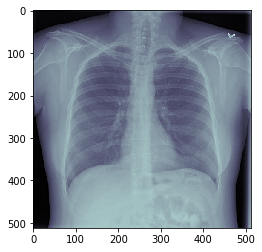

In [20]:
plt.imshow(data['img'].data.cpu().numpy()[0][0], cmap=plt.cm.bone)

In [21]:
def test_learner(learner, dataset, fold, postfix='', idir=PATHS['TEST'], clf_out=False):
    learner.model.eval()
    mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
    std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
    bbox_trans = retinanet.utils.BBoxTransform(mean, std)
    clip_trans = retinanet.utils.ClipBoxes()
    make_anchors = retinanet.anchors.Anchors()
    idir = os.path.join(idir, 'preds', '{}{}'.format(fold, postfix))
    try:
        os.makedirs(idir)
        print('{} created'.format(idir))
    except:
        print('{} exists'.format(idir))

    for data in tqdm(dataset):
        preds = defaultdict(list)

        image = torch.autograd.Variable(data['img']).cuda()
        if len(image.shape) == 3:
            image = image.float().unsqueeze(dim=0)

        output = learner.model(inputs=image.float(), test=True)

        image = image.data.cpu()
        for key in output.keys():
            output[key] = output[key].data.cpu()

        anchors = make_anchors(image).data.cpu()

        for i, el in enumerate(output['bb_reg_out']):
            bbox = bbox_trans(anchors, output['bb_reg_out'][i: i + 1])
            bbox = clip_trans(bbox, image)
            preds['bboxes'].append(bbox.numpy())

        preds['bb_clfs'] = np.array(output['bb_clf_out'].numpy()).astype(np.float16).reshape(-1, 1)

        preds['bboxes'] = np.array(preds['bboxes']).astype(np.uint16).reshape(-1, 4)

        scores_over_thresh = (preds['bb_clfs'] > .05)[:, 0]
        preds['bboxes'] = preds['bboxes'][scores_over_thresh]
        preds['bb_clfs'] = preds['bb_clfs'][scores_over_thresh]

        if clf_out:
            preds['clfs'].append(output['clf_out'].numpy())
            preds['clfs'] = np.array(preds['clfs']).astype(np.float16)        
        np.savez(os.path.join(idir, data['pid'][:-8]), **preds)

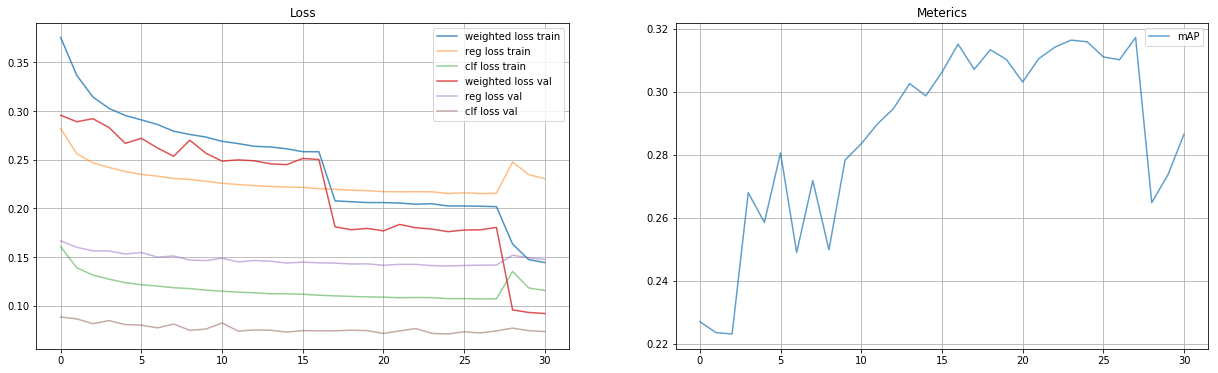

last_epoch: 24
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 0/1000 [00:00<?, ?it/s]

Overlapped keys: 558
../data/test/preds/0_resnet101 exists


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


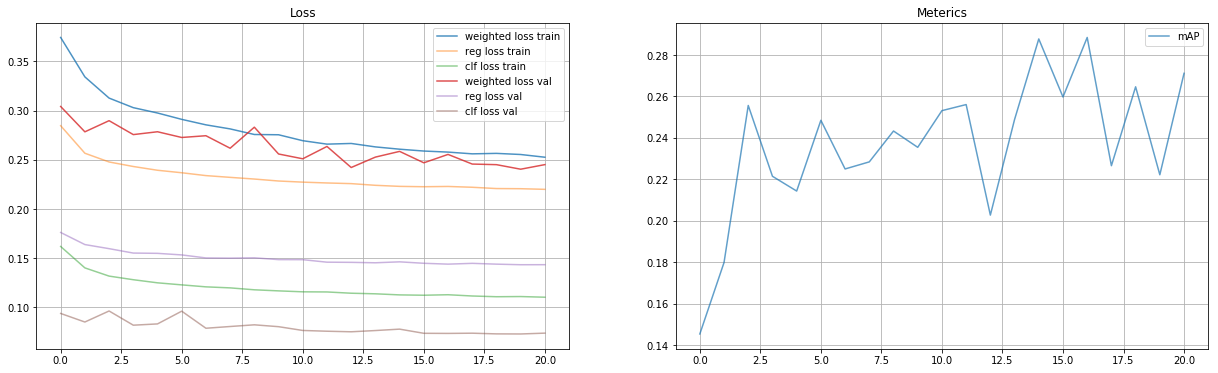

last_epoch: 19
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 1/1000 [00:00<02:21,  7.07it/s]

Overlapped keys: 558
../data/test/preds/1_resnet101 exists


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


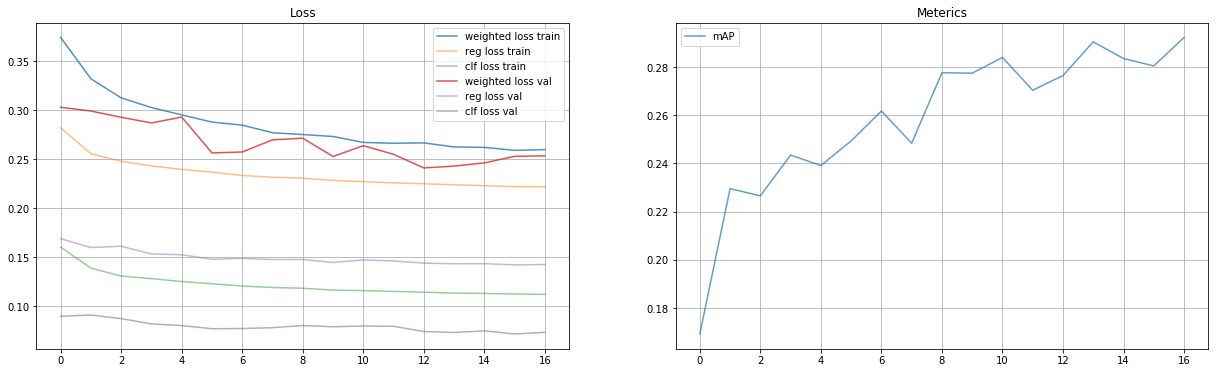

last_epoch: 15
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 1/1000 [00:00<02:22,  7.03it/s]

Overlapped keys: 558
../data/test/preds/2_resnet101 exists


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


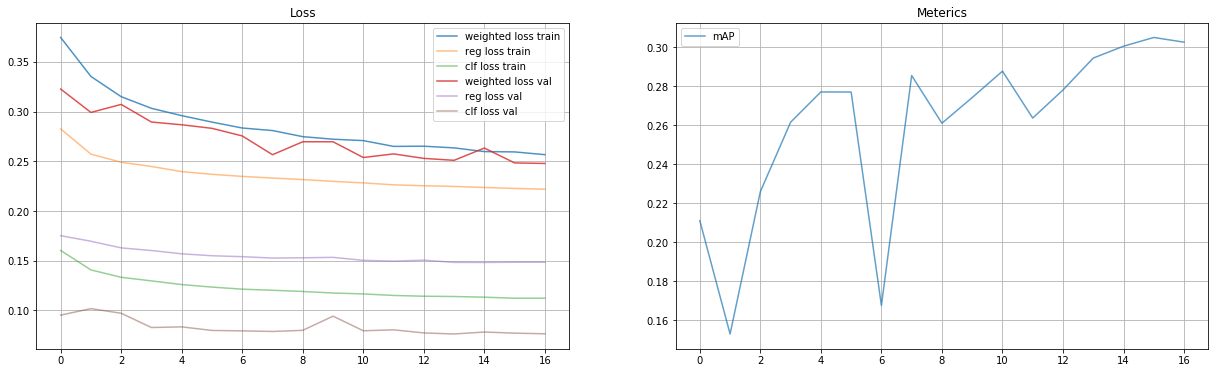

last_epoch: 15
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 1/1000 [00:00<02:20,  7.12it/s]

Overlapped keys: 558
../data/test/preds/3_resnet101 exists


100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]


In [22]:
checkpoints_pth = '../data/models/retinanet_resnet101/'
postfix='_resnet101'

paths_df = pd.read_csv('../data/csv/stage_1_sample_submission.csv')
paths_df['ImageId'] = paths_df.patientId.apply(lambda x: x + '.dcm.png')
paths = ds.get_paths(paths_df, root_dir=PATHS['TEST'])

for fold in range(4):
    history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
    last_epoch = max(15, last_epoch)

    visualisation.plot_retina_losses(history)
    print('last_epoch: {}'.format(last_epoch))

    dataset = BBoxTestDataset(paths, df, ddf, scale=2.)
    model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, num_classes_general=3, dropouts=[.2, .3], make_clf=True)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
    learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

    preds = test_learner(learner, dataset, fold, postfix=postfix, idir=PATHS['TEST'], clf_out=True)

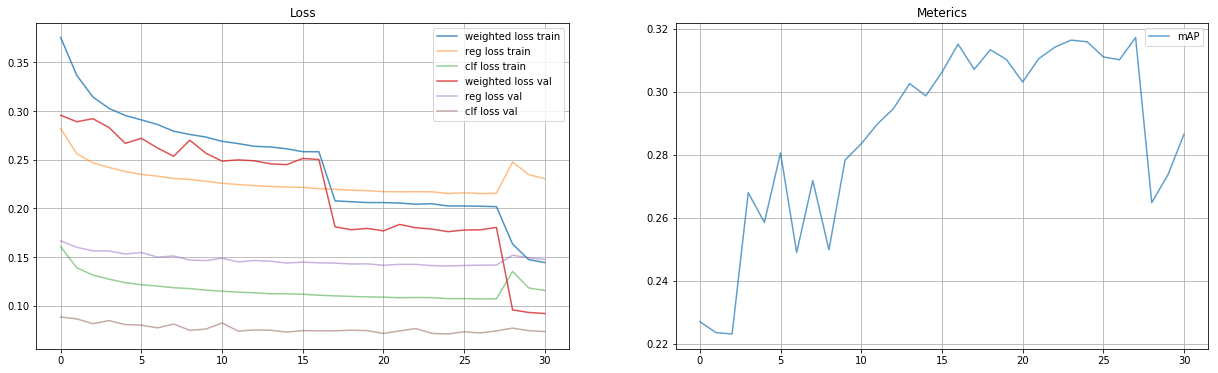

last_epoch: 24
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 0/3000 [00:00<?, ?it/s]

Overlapped keys: 558
../data/test2/preds/0_resnet101 created


100%|██████████| 3000/3000 [02:51<00:00, 17.48it/s]


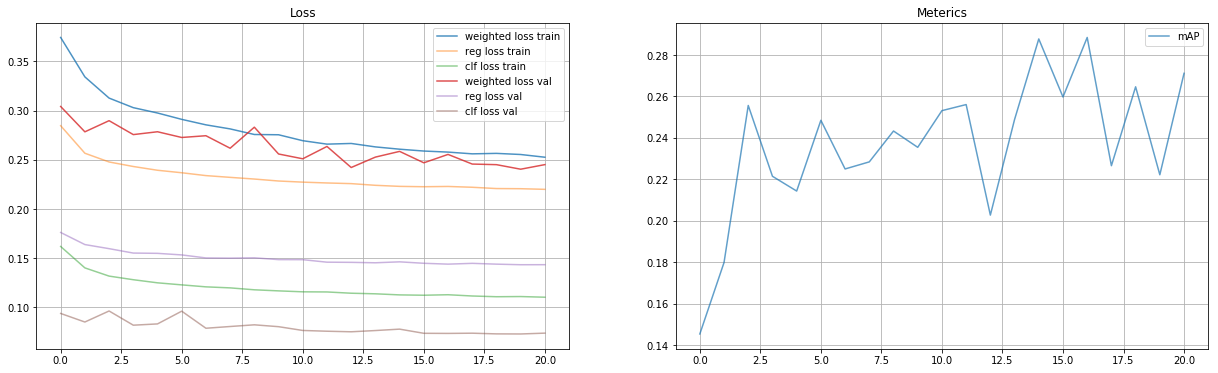

last_epoch: 19
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 2/3000 [00:00<02:38, 18.87it/s]

Overlapped keys: 558
../data/test2/preds/1_resnet101 created


100%|██████████| 3000/3000 [03:26<00:00, 14.55it/s]


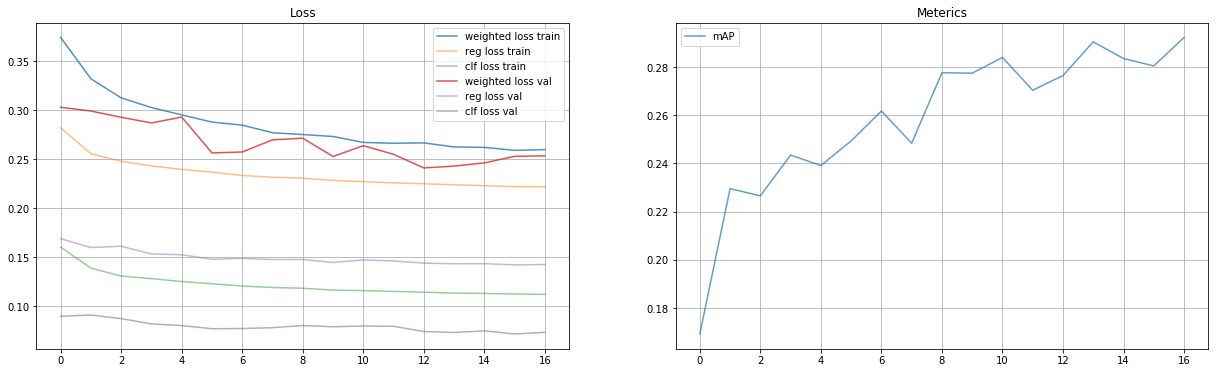

last_epoch: 15
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 0/3000 [00:00<?, ?it/s]

Overlapped keys: 558
../data/test2/preds/2_resnet101 created


100%|██████████| 3000/3000 [02:52<00:00, 17.36it/s]


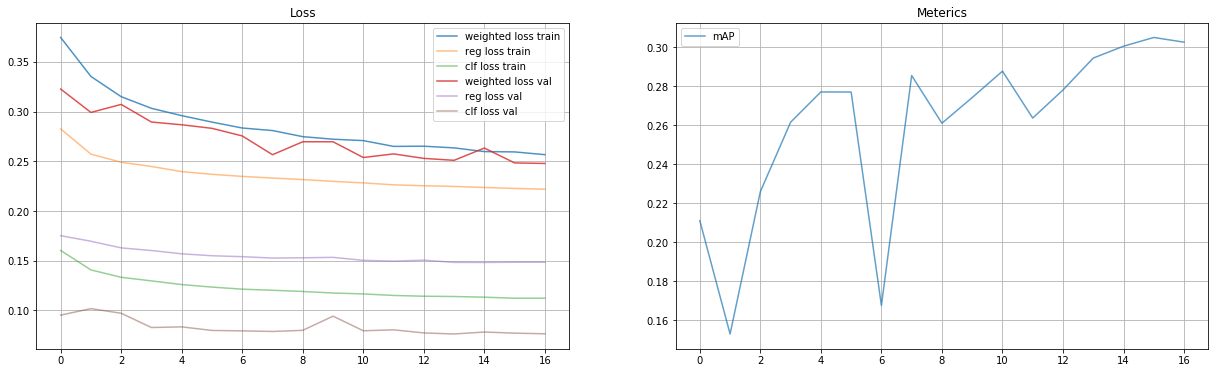

last_epoch: 15
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight


  0%|          | 2/3000 [00:00<02:45, 18.06it/s]

Overlapped keys: 558
../data/test2/preds/3_resnet101 created


100%|██████████| 3000/3000 [02:53<00:00, 17.30it/s]


In [23]:
for fold in range(4):
    history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
    last_epoch = max(15, last_epoch)

    visualisation.plot_retina_losses(history)
    print('last_epoch: {}'.format(last_epoch))

    dataset = BBoxTestDataset(paths, df, ddf, scale=1.)
    model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, num_classes_general=3, dropouts=[.2, .3], make_clf=True)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
    learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

    preds = test_learner(learner, dataset, fold, postfix=postfix, idir=PATHS['TEST2'])

In [32]:
paths_df = pd.read_csv('../data/csv/stage_2_sample_submission.csv')
paths_df['ImageId'] = paths_df.patientId.apply(lambda x: x + '.dcm.png')
paths = ds.get_paths(paths_df, root_dir=PATHS['TEST2'])

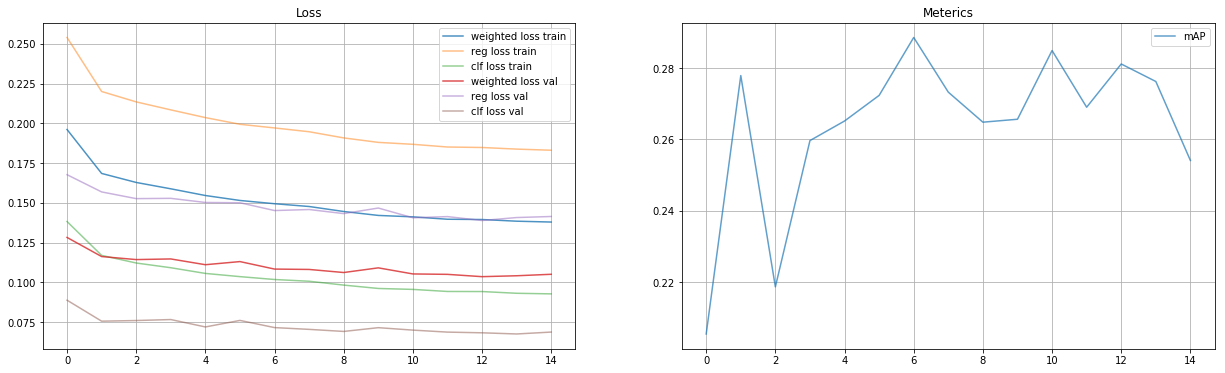

last_epoch: 14
Overlapped keys: 265
Poped keys: []
Summed over: weight


  0%|          | 3/3000 [00:00<02:06, 23.74it/s]

Overlapped keys: 301
../data/test2/preds/1resnet50_no_clf_last_wd created


100%|██████████| 3000/3000 [02:09<00:00, 23.17it/s]


In [38]:
last_epochs = {
    0: 14,
    1: 14,
}

checkpoints_pth = '../data/models/retinanet_resnet50_no_clf_last_wd/'
postfix='resnet50_no_clf_last_wd'

for fold in range(2):
    history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
    last_epoch = 14

    visualisation.plot_retina_losses(history)
    print('last_epoch: {}'.format(last_epoch))

    dataset = BBoxTestDataset(paths, df, ddf, scale=1.)
    model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
    learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

    preds = test_learner(learner, dataset, fold, postfix=postfix, idir=PATHS['TEST2'])

In [40]:
last_epochs = {
    0: 21,
}

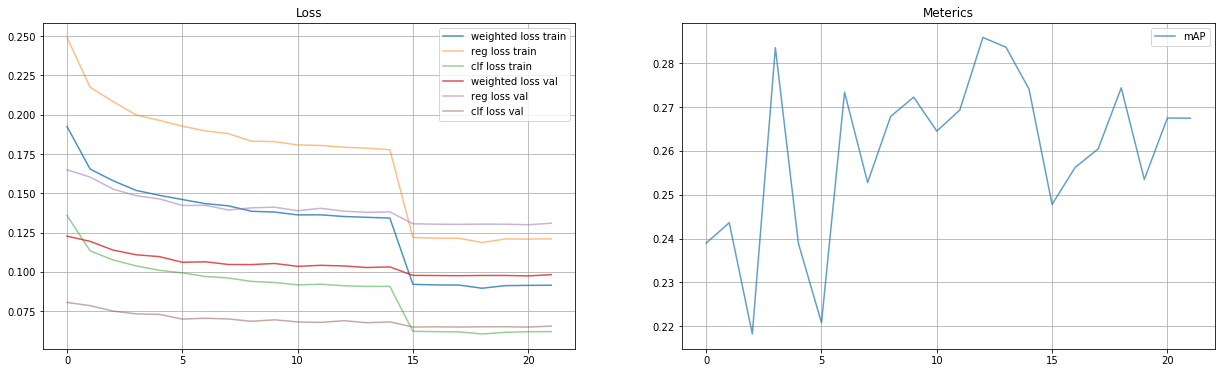

last_epoch: 21
Overlapped keys: 265
Poped keys: []
Summed over: weight


  0%|          | 3/3000 [00:00<02:00, 24.83it/s]

Overlapped keys: 301
../data/test2/preds/0resnet50_no_clf_last created


100%|██████████| 3000/3000 [02:08<00:00, 23.42it/s]


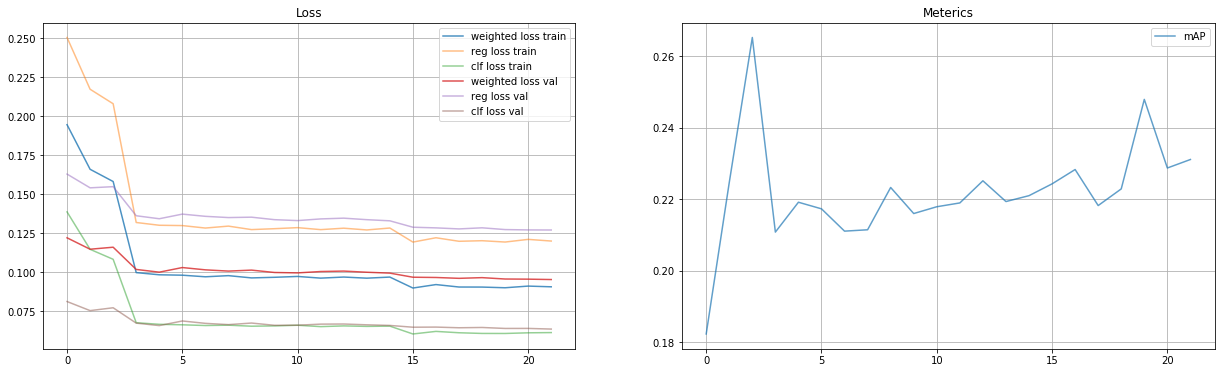

last_epoch: 21
Overlapped keys: 265
Poped keys: []
Summed over: weight


  0%|          | 3/3000 [00:00<02:08, 23.39it/s]

Overlapped keys: 301
../data/test2/preds/1resnet50_no_clf_last created


100%|██████████| 3000/3000 [02:09<00:00, 23.11it/s]


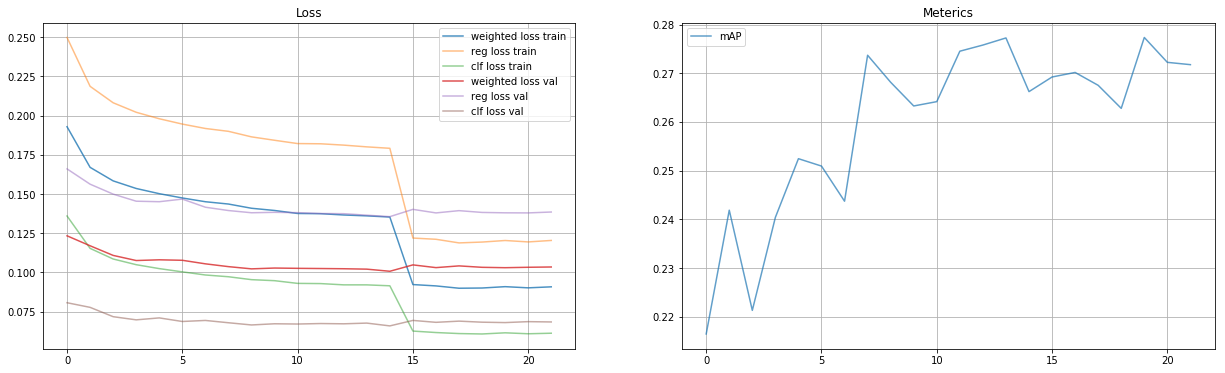

last_epoch: 14
Overlapped keys: 265
Poped keys: []
Summed over: weight


  0%|          | 3/3000 [00:00<02:43, 18.29it/s]

Overlapped keys: 301
../data/test2/preds/2resnet50_no_clf_last created


100%|██████████| 3000/3000 [02:09<00:00, 23.15it/s]


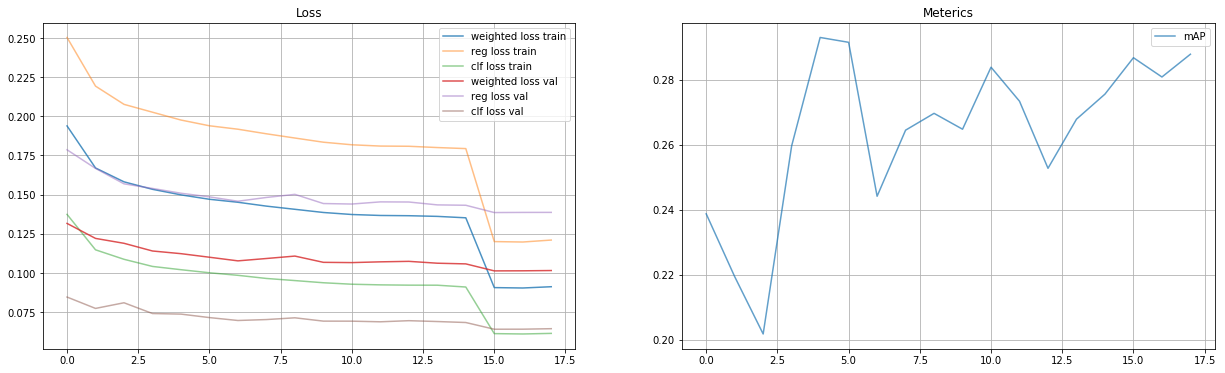

last_epoch: 15
Overlapped keys: 265
Poped keys: []
Summed over: weight


  0%|          | 2/3000 [00:00<02:48, 17.84it/s]

Overlapped keys: 301
../data/test2/preds/3resnet50_no_clf_last created


100%|██████████| 3000/3000 [02:09<00:00, 23.15it/s]


In [42]:
checkpoints_pth = '../data/models/retinanet_resnet50_no_clf_last/'
postfix='resnet50_no_clf_last'

for fold in range(4):
    history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
    if fold in last_epochs.keys():
        last_epoch = last_epochs[fold]

    visualisation.plot_retina_losses(history)
    print('last_epoch: {}'.format(last_epoch))

    dataset = BBoxTestDataset(paths, df, ddf, scale=1.)
    model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
    learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

    preds = test_learner(learner, dataset, fold, postfix=postfix, idir=PATHS['TEST2'])

In [27]:
last_epochs = {
    0: 24,
    1: 21,
    2: 21,
    3: 21,
}

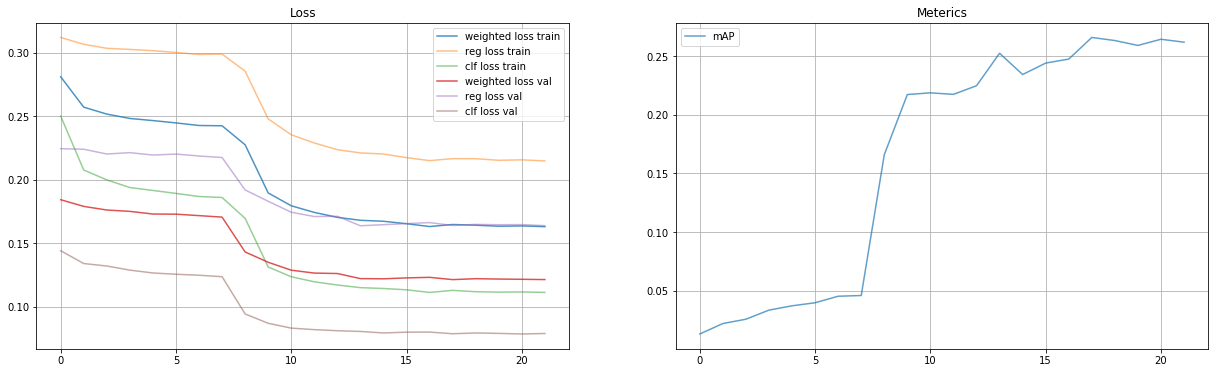

last_epoch: 21
Overlapped keys: 180
Poped keys: []
Summed over: weight


  0%|          | 3/3000 [00:00<02:07, 23.42it/s]

Overlapped keys: 216
../data/test2/preds/3_34_no_clf created


100%|██████████| 3000/3000 [01:53<00:00, 26.53it/s]


In [28]:
checkpoints_pth = '../data/models/retinanet_resnet34_no_clf/'
postfix='_34_no_clf'

for fold in range(3, 4):
    history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
    if fold in last_epochs.keys():
        last_epoch = last_epochs[fold]

    visualisation.plot_retina_losses(history)
    print('last_epoch: {}'.format(last_epoch))

    dataset = BBoxTestDataset(paths, df, ddf, scale=1.)
    model = retinanet.model.resnet34(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
    learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

    preds = test_learner(learner, dataset, fold, postfix=postfix, idir=PATHS['TEST2'])

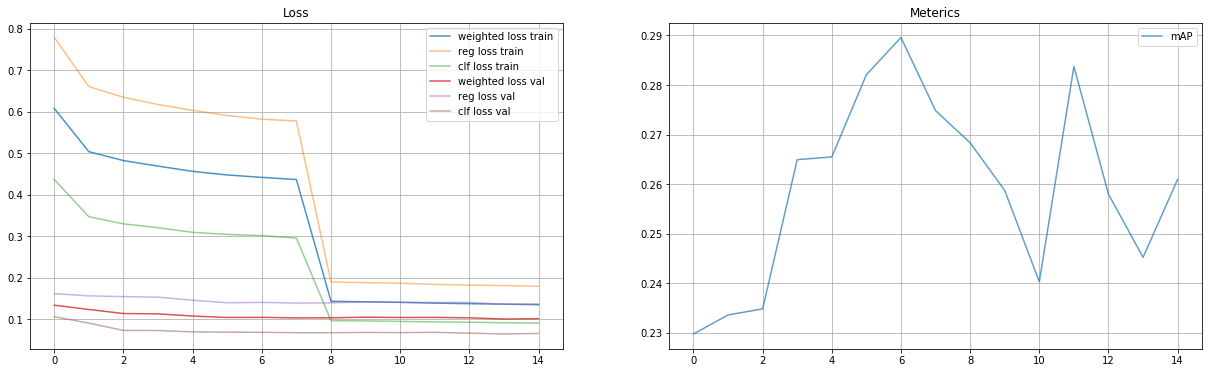

last_epoch: 14
Overlapped keys: 520
Poped keys: []
Summed over: weight


  0%|          | 1/3000 [00:00<06:39,  7.51it/s]

Overlapped keys: 556
../data/test2/preds/2retinanet_resnet101_no_clf_last_wd created


100%|██████████| 3000/3000 [02:54<00:00, 17.18it/s]


In [32]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last_wd/'
postfix='retinanet_resnet101_no_clf_last_wd'
last_epochs = { 2: 14 }

for fold in range(2, 3):
    history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
    last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
    if fold in last_epochs.keys():
        last_epoch = last_epochs[fold]

    visualisation.plot_retina_losses(history)
    print('last_epoch: {}'.format(last_epoch))

    dataset = BBoxTestDataset(paths, df, ddf, scale=1.)
    model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
    learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

    preds = test_learner(learner, dataset, fold, postfix=postfix, idir=PATHS['TEST2'])

In [33]:
checkpoints_pth = '../data/models/retinanet_resnet50_no_clf_last_wd'
postfix='resnet50_no_clf_last_wd'

In [1]:
fold = 0

history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']]) + 1

last_epoch = 14

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, scale=.5)
model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

NameError: name 'pickle' is not defined

In [30]:
preds = test_learner(learner, dataset, fold, postfix=postfix)

  0%|          | 2/1000 [00:00<00:55, 17.97it/s]

../data/test/preds/0resnet50_no_clf_last_wd created


100%|██████████| 1000/1000 [00:45<00:00, 21.87it/s]


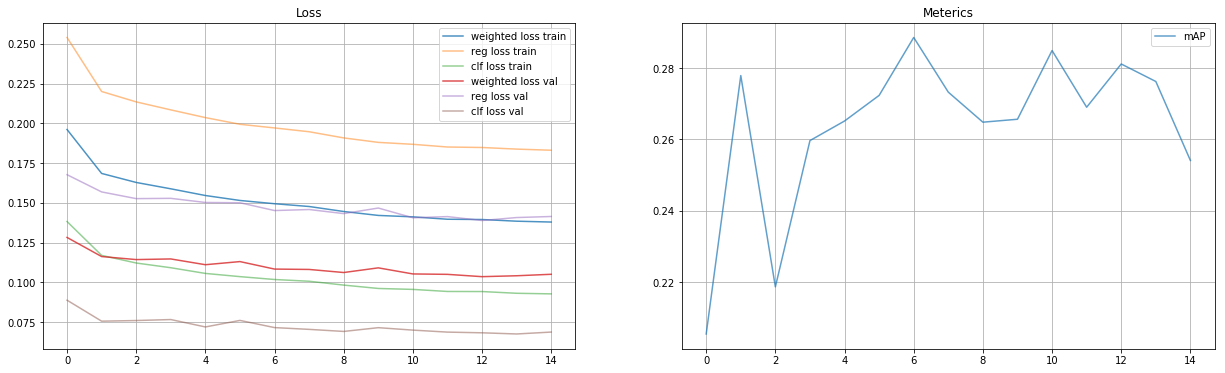

last_epoch: 14
Overlapped keys: 265
Poped keys: []
Summed over: weight
Overlapped keys: 301


In [34]:
fold = 1

history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])

last_epoch = 14

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, scale=.5)
model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

In [35]:
preds = test_learner(learner, dataset, fold, postfix=postfix)

  0%|          | 2/1000 [00:00<00:52, 19.05it/s]

../data/test/preds/1resnet50_no_clf_last_wd created


100%|██████████| 1000/1000 [00:45<00:00, 21.90it/s]


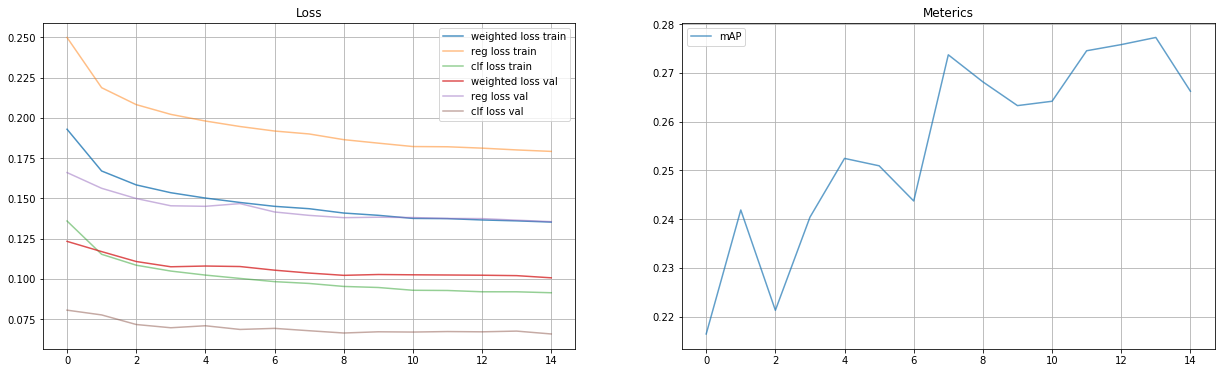

last_epoch: 14
Overlapped keys: 265
Poped keys: []
Summed over: weight
Overlapped keys: 301


In [32]:
fold = 2

history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']][:15])

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, scale=.5)
model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

In [33]:
preds = test_learner(learner, dataset, fold, postfix=postfix)

  0%|          | 3/1000 [00:00<00:47, 20.96it/s]

../data/test/preds/250_no_clf_last created


100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


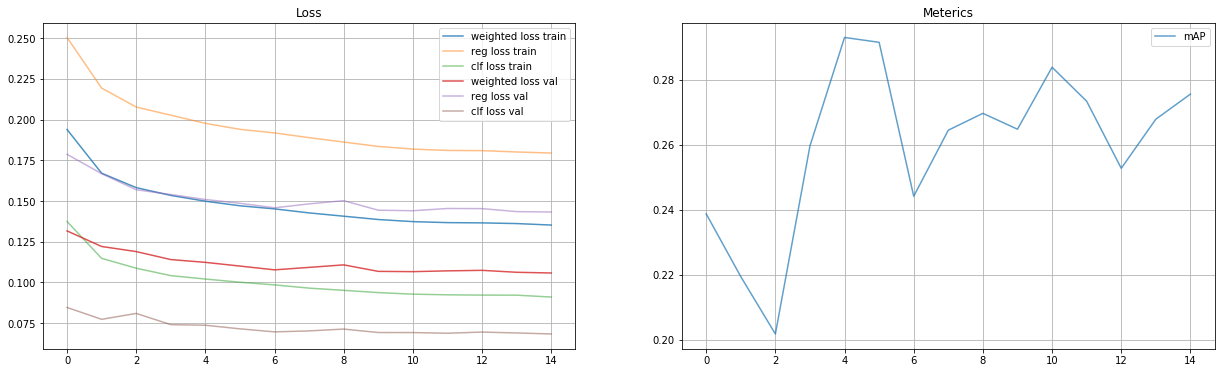

last_epoch: 14
Overlapped keys: 265
Poped keys: []
Summed over: weight
Overlapped keys: 301


In [36]:
fold = 3

history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']][:15])

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, scale=.5)
model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

In [37]:
preds = test_learner(learner, dataset, fold, postfix=postfix)

  0%|          | 2/1000 [00:00<01:03, 15.64it/s]

../data/test/preds/350_no_clf_last created


100%|██████████| 1000/1000 [00:46<00:00, 21.47it/s]


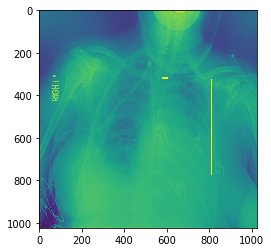

In [187]:
bbox = bboxes[3:, :, 194786].mean(0).astype(np.int)[0]

plt.imshow(visualisation.visualize_bbox(((image.data.cpu().numpy()[3, 0] * ds.STD + ds.MEAN) * 255).astype(np.uint8), bbox, 1, {1: 'pnm'}))

# Inference over dataset

In [105]:
import joblib

In [106]:
idir = os.path.join(PATHS['TRAIN'])
mdir = os.path.join(PATHS['TRAIN'], 'masks')
paths = glob(os.path.join(idir, 'png', '*.png'))
paths = [os.path.basename(path) for path in paths]
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [107]:
aug = lambda x: { k: cv2.resize(v, (256, 256)) for k, v in x.items() if v is not None}

In [108]:
paths = ds.get_paths(paths_df, root_dir=idir)
dataset = ds.CXR_Dataset(paths, augmentations=aug)
datagen = torch.utils.data.DataLoader(dataset,
                                      shuffle=False,
                                      batch_size=1,
                                      num_workers=0)

In [59]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return origs

In [16]:
# plt.imshow((image[0, ..., 0] - ds.MEAN) / ds.STD)

In [60]:
last_iter = 190
checkpoints_pth = '../data/models/albunet_BNdec/'
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')

cnn_pool = list()
for fold in range(4):
    model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
    model = thf.get_model(model, checkpoint=checkpoints.format(fold, last_iter), devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()
    cnn_pool.append(model)


Overlapped keys: 480
Overlapped keys: 480
Overlapped keys: 480
Overlapped keys: 480


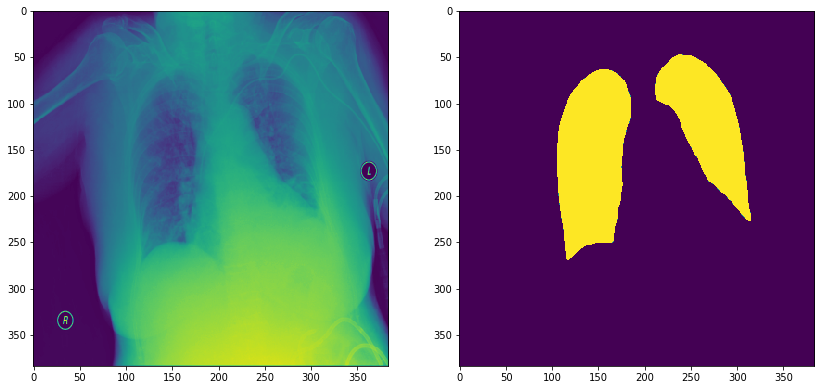

25684it [2:07:43,  3.35it/s]


In [40]:
for i, (k, v) in tqdm(enumerate(paths.items())):
    image = cv2.imread(v['image'])
    image = cv2.resize(image, (384, 384), interpolation=cv2.INTER_AREA)
    image = (image[..., :1] / 255. - ds.MEAN) / ds.STD
    images = _rotate_mirror_do(image)
    images = torch.tensor(np.rollaxis(images.astype(np.float32), 3, 1))

    with torch.no_grad():
        preds_ = list()
        images = torch.autograd.Variable(images).cuda()
        for cnn in cnn_pool:
            pred = torch.sigmoid(cnn(images))
            preds_.append(pred.data.cpu().numpy())

    preds = list()
    for pred in preds_:
        preds += _rotate_mirror_undo(np.rollaxis(pred, 1, 4))

    pred = 255 * np.median(np.array(preds) > .5, axis=0).squeeze()
    cv2.imwrite(os.path.join(mdir, k), pred.astype(np.uint8))

    if i % 100 == 0:
        clear_output()
        _, ax = plt.subplots(ncols=2, figsize=(14, 7))
        ax[0].imshow(np.squeeze(image))
        ax[1].imshow(np.squeeze(pred))
        plt.show()
